In [2]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 799.3 kB/s eta 0:00:00m eta 0:00:010:00:03


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_roi(img, threshold):
    if len(img.shape) != 2:
        raise ValueError("Input image must be grayscale")
    roi_mask = (img < threshold).astype(np.uint8)
    return roi_mask

In [7]:
# def normalized_projection(img, roi_mask):
#     proj = np.sum(img * roi_mask, axis=1)
#     norm = np.sum(roi_mask, axis=1)
#     norm[norm == 0] = 1
#     b = proj / norm 
#     return b

# def dft_features(b):
#     padded_b = np.pad(b, (0, 240 - len(b)))
#     dft = np.fft.fft(padded_b)
#     #dft = np.fft.fft(b, n = 240) # according to the formula provided as it was truncated at 240
#     features = np.abs(dft[:15])
#     return features

In [8]:
def normalized_projection(img, roi_mask):
    proj = np.sum(img * roi_mask, axis = 1)
    norm = np.sum(roi_mask, axis = 1)
    b = np.zeros_like(proj, dtype=float)
    for i in range(len(b)):
        if norm[i]>0:
            b[i] = proj[i]/norm[i]
    return b

# def dft_features(b):
#     """Equation 6 implementation matching the document specifications"""
#     if len(b) < 240:
#         b_padded = np.pad(b, (0, 240 - len(b)), mode='constant')
#     else:
#         b_padded = b[:240]
    
#     N = 240
#     n_values = np.arange(1, 16)  # 1-15 for bins centered at 10-150 cycles/inch
#     features = np.zeros(15)
    
#     for i, n in enumerate(n_values):
#         kn = np.arange(N) * n  # matching e^{-j*2π*kn/10} in the paper
#         dft_val = np.sum(b_padded * np.exp(-1j * 2 * np.pi * kn / N))
#         features[i] = np.abs(dft_val)
    
#     return features

def dft_features(b):
    """More direct implementation of Equation 6"""
    if len(b) < 240:
        b_padded = np.pad(b, (0, 240 - len(b)), mode='constant')
    else:
        b_padded = b[:240]
    
    N = 240
    features = np.zeros(15)
    
    # Frequencies centered at [10,20,...,150] cycles/inch
    for i in range(15):
        n = (i + 1) * 10  # 10,20,...,150
        # Calculate the DFT at frequency n
        dft_val = 0
        for k in range(N):
            dft_val += b_padded[k] * np.exp(-1j * 2 * np.pi * n * k / N)
        features[i] = np.abs(dft_val)
    
    return features

In [9]:
image_path = "/home/khushi/Desktop/CV_Printer_Identification/Extracted_e/e_1.png"
gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
"""
what is the point of selecting threshold as 256????? Are we taking the entire image....extracted e's right?
"""
roi_mask = extract_roi(gray_img, threshold=128)
b_vector = normalized_projection(gray_img, roi_mask)
features_15_dft = dft_features(b_vector)

print("15-band DFT features:\n", features_15_dft)

15-band DFT features:
 [307.85556314 139.54863623 191.19960764  73.84532446 178.71592807
 123.57029601 115.51599699  76.51828939 178.93590266  84.73240764
 122.88877701  42.41666667 122.88877701  84.73240764 178.93590266]


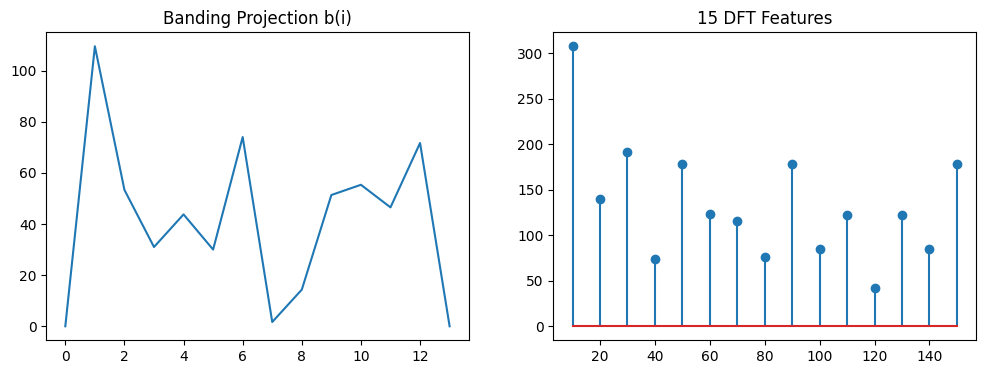

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(b_vector)
plt.title("Banding Projection b(i)")

plt.subplot(122)
plt.stem(np.arange(10, 160, 10), features_15_dft) 
plt.title("15 DFT Features")
plt.show()

In [11]:
def compute_variance(img, roi_mask):
    roi_indices = np.where(roi_mask)
    roi_pixels = img[roi_indices]
    R = len(roi_pixels)
    if R == 0:
        return 0
    mu = np.mean(roi_pixels)
    variance = np.sum((roi_pixels - mu)**2)/R # variance
    return variance


def compute_entropy(img, roi_mask):
    roi_indices = np.where(roi_mask)
    roi_pixels = img[roi_indices]
    R = len(roi_pixels)
    if R == 0:
        return 0

    hist, _ = np.histogram(roi_pixels, bins=256, range=(0, 255)) # probability density function
    p = hist / R  # p_Img(alpha)
    entropy = -np.sum(p * np.log2(p + 1e-10)) # this is added to avoid log 0 ...can think of it as a small value epsilon
    return entropy

In [12]:
image_path = "/home/khushi/Desktop/CV_Printer_Identification/Extracted_e/e_1.png"
gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

roi_mask = extract_roi(gray_img, threshold=128)
variance = compute_variance(gray_img, roi_mask)
entropy = compute_entropy(gray_img, roi_mask)

print(f"{variance:.2f}")
print(f"{entropy:.2f}")

1964.86
4.76


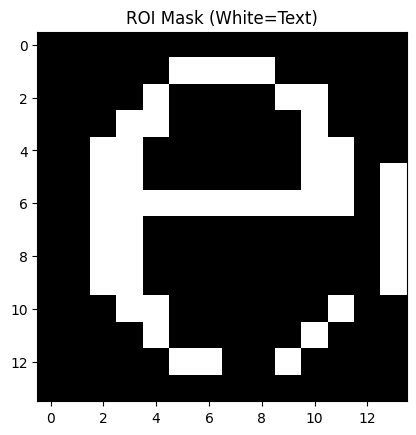

ROI Pixels:
 [126 104 106 102  27  27 106  16  77   0  95   0  10  70  14   0  52  26
  58   0   2 115 116 116 116 116 116  56  48  13   0   4   1   7   0  36
  61   0  93   4  91  71   3  90  45  88  82]


In [15]:
plt.imshow(roi_mask, cmap='gray')
plt.title("ROI Mask (White=Text)")
plt.show()

roi_indices = np.where(roi_mask)
roi_pixels = gray_img[roi_indices]  
print("ROI Pixels:\n", roi_pixels)

In [17]:
print("ROI intensity stats:")
print(f"Min: {roi_pixels.min()}, Max: {roi_pixels.max()}")
print(f"Mean: {roi_pixels.mean():.2f}, Median: {np.median(roi_pixels)}")


ROI intensity stats:
Min: 0, Max: 126
Mean: 53.32, Median: 52.0
